### Markov Chains Supermarket Simulation

In [1914]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import choices, sample, randint

In [959]:
# Import data with datetime index
mon = pd.read_csv('../data/monday.csv', delimiter=';', parse_dates=True, index_col=0)
tue = pd.read_csv('../data/tuesday.csv', delimiter=';', parse_dates=True, index_col=0)
wed = pd.read_csv('../data/wednesday.csv', delimiter=';', parse_dates=True, index_col=0)
thu = pd.read_csv('../data/thursday.csv', delimiter=';', parse_dates=True, index_col=0)
fri = pd.read_csv('../data/friday.csv', delimiter=';', parse_dates=True, index_col=0)

### Data wrangling

In [960]:
def weekday_id(df, prefix):
    """
    Returns the given DataFrame's 'customer_no' column
    with the given prefix to create unique identifiers.
    """
    df['customer_no'] = df['customer_no'].astype(str) 
    df['customer_no'] = prefix + df['customer_no']

In [961]:
# Create unique identifiers for each customer based on weekday
weekday_id(mon, 'a_')
weekday_id(tue, 'b_')
weekday_id(wed, 'c_')
weekday_id(thu, 'd_')
weekday_id(fri, 'e_')

In [962]:
# Combine all into one DataFrame
df = pd.concat([mon, tue, wed, thu, fri])

In [963]:
# Create time column
df['datetime'] = df.index

Create checkout time for customers without one. 

In [964]:
# Create new column with the last location for each customer
df['last_location'] = df.groupby(['customer_no'])['location'].transform('last')

# Create DF of all customers whose last location was NOT the checkout
c = df.loc[df['last_location'] != 'checkout']

# Create new column with the last time for each customer in the store
c['last_time'] = c.groupby(['customer_no'])['datetime'].transform('last')

# Delete duplicate rows for each customer, keep only the row with the latest time 
c['customer_no'].drop_duplicates(keep='last', inplace=False)

# Create new column with checkout time 2 minutes after the latest time for each customer
c['checkout time'] = c['last_time'] + pd.DateOffset(minutes=2)

# Change all locations to checkout
c['location'] = 'checkout'

/var/folders/k6/wmjvb66j4r943l227ljx40000000gn/T/ipykernel_3944/651937279.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['last_time'] = c.groupby(['customer_no'])['datetime'].transform('last')
/var/folders/k6/wmjvb66j4r943l227ljx40000000gn/T/ipykernel_3944/651937279.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c['checkout time'] = c['last_time'] + pd.DateOffset(minutes=2)
/var/folders/k6/wmjvb66j4r943l227ljx40000000gn/T/ipykernel_3944/651937279.py:17: SettingWithCopyWarning: 
A value is tryin

In [965]:
# Drop and rename columns to prepare to merge with main DF
c.drop(columns=['datetime', 'last_location', 'last_time'], inplace=True)
c = c.rename(columns={'checkout time':'datetime'}) 
df.drop(columns=['last_location'], inplace=True)

/Users/happyflower/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [966]:
# Update index to reflect updated datetime
c.set_index('datetime', inplace=True)
c['datetime'] = c.index

In [967]:
# Merge DFs, adding new rows with checkout times for customers missing them
df = df.append(c)

# Drop duplicate rows
df = df.drop_duplicates()

In [1003]:
# Resample times by minute for each customer
df2 = df.groupby(['customer_no']).resample('min').ffill()

# Drop duplicate column already in index
df2.drop(columns=['customer_no'], inplace=True)

# Reset index - flatten multiindex
df2.reset_index(inplace=True)

# Rename resampled datetime column and set as index
df2 = df2.rename(columns={'level_1':'timestamp'})
df2.set_index('timestamp', inplace=True)

# Update datetime column 
df2['datetime'] = df2.index

# Update DF
df = df2

In [978]:
df.head()

,customer_no,location,datetime
timestamp,,,
2019-09-02 07:03:00,a_1,dairy,2019-09-02 07:03:00
2019-09-02 07:04:00,a_1,dairy,2019-09-02 07:04:00
2019-09-02 07:05:00,a_1,checkout,2019-09-02 07:05:00
2019-09-02 07:06:00,a_10,fruit,2019-09-02 07:06:00
2019-09-02 07:07:00,a_10,fruit,2019-09-02 07:07:00


### Data exploration

In [891]:
df['location'].unique()

array(['dairy', 'checkout', 'fruit', 'drinks', 'spices'], dtype=object)

In [892]:
# Total number of customers in each section
df.groupby(['location'])['customer_no'].nunique()

location
checkout    7445
dairy       3818
drinks      3214
fruit       4284
spices      2938
Name: customer_no, dtype: int64

In [893]:
df['hour'] = df.index.hour

In [894]:
# No. of customers per section per hour
section_traffic_hr = pd.DataFrame(df3.groupby(['location', 'hour'])['customer_no'].nunique())
section_traffic_hr.head(2)

customer_no
location hour             
checkout 7             454
         8             677

In [895]:
checkout = df.loc[df['location'] == 'checkout']

In [896]:
# No. of customers at checkout per hour
checkout.groupby(['hour'])['customer_no'].nunique()

hour
7     454
8     677
9     455
10    427
11    342
12    384
13    514
14    496
15    412
16    518
17    556
18    630
19    755
20    492
21    333
Name: customer_no, dtype: int64

In [900]:
df.drop(columns=['hour'], inplace=True)

In [897]:
df2 = df.reset_index()

In [898]:
duration = pd.DataFrame(df2.groupby(['customer_no'])['timestamp'].max() - df2.groupby(['customer_no'])['timestamp'].min())

In [899]:
# Amount of time each customer spent in the market
duration.sort_values(['timestamp'])

,timestamp
customer_no,
b_246,0 days 00:01:00
c_1053,0 days 00:01:00
d_139,0 days 00:01:00
d_1394,0 days 00:01:00
d_1395,0 days 00:01:00
...,...
e_1238,0 days 00:49:00
a_666,0 days 00:51:00
c_710,0 days 00:51:00


### Transition Probabilities

In [1198]:
# Add entrance time for each customer
e = df.copy()

# Group customers based on time and get first time in store
e['first_time'] = e.groupby(['customer_no'])['datetime'].transform('first')

In [1199]:
# Add new column with the first time -2 min to create entrance time
e['entrance_time'] = e['first_time'] + pd.DateOffset(minutes=-2)

# Change location to entrance for all
e['location'] = 'entrance'

In [1200]:
# Drop and rename columns to prepare to merge with main DF
e.drop(columns=['datetime', 'first_time'], inplace=True)
e = e.rename(columns={'entrance_time':'datetime'}) 

In [1201]:
# Update index to reflect updated datetime
e.set_index('datetime', inplace=True)
e['datetime'] = e.index

In [1207]:
# Keep only the first time and drop duplicate
e.drop_duplicates(subset='customer_no', inplace=True)

In [1208]:
e

,customer_no,location,after,datetime
datetime,,,,
2019-09-02 07:01:00,a_1,entrance,dairy,2019-09-02 07:01:00
2019-09-02 07:04:00,a_10,entrance,fruit,2019-09-02 07:04:00
2019-09-02 07:54:00,a_100,entrance,drinks,2019-09-02 07:54:00
2019-09-02 17:42:00,a_1000,entrance,dairy,2019-09-02 17:42:00
2019-09-02 17:43:00,a_1001,entrance,checkout,2019-09-02 17:43:00
...,...,...,...,...
2019-09-06 17:15:00,e_995,entrance,checkout,2019-09-06 17:15:00
2019-09-06 17:15:00,e_996,entrance,spices,2019-09-06 17:15:00
2019-09-06 17:16:00,e_997,entrance,fruit,2019-09-06 17:16:00


In [1212]:
# Add entrance times to main DF
df = df.append(e)

In [1223]:
# Order values to prepare for shift column
df.sort_values(by=['customer_no', 'datetime'], axis=0, ascending=True, inplace=True)

In [1225]:
# Create shift column to calculate transitional probabilities
df['location_after'] = df['location'].shift(-1)

In [1227]:
# Since the checkout is terminal state, change location after to checkout when starting at checkout
df['location_after'] = df.apply(lambda x: 'checkout' if x['location']=='checkout' else x['location_after'], axis=1)

In [1229]:
# Calculate transition probabilities
probs = pd.crosstab(df['location'], df['location_after'], normalize=0) # normalizing along the rows

In [1230]:
probs

location_after,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.103384,0.736957,0.058523,0.049809,0.051327
drinks,0.215666,0.010896,0.598581,0.087891,0.086965
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.201494,0.095871,0.054817,0.597169,0.050649
spices,0.150565,0.193061,0.162979,0.090880,0.402515


### Predict based on probabilities

In [1233]:
# Make sure each row of the probabilities sums to 1
assert all(probs.sum(axis=1) > 0.999)

In [1234]:
probs

location_after,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.103384,0.736957,0.058523,0.049809,0.051327
drinks,0.215666,0.010896,0.598581,0.087891,0.086965
entrance,0.000000,0.287576,0.153526,0.377435,0.181464
fruit,0.201494,0.095871,0.054817,0.597169,0.050649
spices,0.150565,0.193061,0.162979,0.090880,0.402515


In [1235]:
#P = probs.to_numpy()

In [1236]:
# 100 customers start a the entrance
start = np.array([0, 0, 0, 100, 0, 0])
start

array([  0,   0,   0, 100,   0,   0])

In [1237]:
# In which section will the customers most likely be in the next minute?
start.dot(probs).round()

array([ 0., 29., 15., 38., 18.])

In [1296]:
probs['entrance'] = 0.0

In [1335]:
probs = probs.reindex(columns=['entrance', 'dairy', 'drinks', 'fruit', 'spices', 'checkout'])

In [1336]:
P = probs.to_numpy()
P

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.        , 0.7369575 , 0.0585226 , 0.04980886, 0.05132674,
        0.1033843 ],
       [0.        , 0.01089638, 0.59858141, 0.08789062, 0.08696546,
        0.21566612],
       [0.        , 0.28757555, 0.15352586, 0.37743452, 0.18146407,
        0.        ],
       [0.        , 0.09587102, 0.05481715, 0.5971687 , 0.05064884,
        0.2014943 ],
       [0.        , 0.19306064, 0.16297947, 0.09088015, 0.40251472,
        0.15056502]])

### Create classes

In [1915]:
STATES = ['entrance', 'dairy', 'drinks', 'fruit', 'spices', 'checkout']

TRAN_PROBS = {'entrance': (0.        , 0.28757555, 0.15352586, 0.37743452, 0.18146407,
        0.        ),
       'dairy': (0.        , 0.7369575 , 0.0585226 , 0.04980886, 0.05132674,
        0.1033843 ),
       'drinks': (0.        , 0.01089638, 0.59858141, 0.08789062, 0.08696546,
        0.21566612),
       
       'fruit': (0.        , 0.09587102, 0.05481715, 0.5971687 , 0.05064884,
        0.2014943 ),
       'spices': (0.        , 0.19306064, 0.16297947, 0.09088015, 0.40251472,
        0.15056502),
        'checkout': (0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        )
        } 

PRICES = {'dairy': 5, 
          'drinks': 6,
          'fruit': 4, 
          'spices': 3,
         }

In [1851]:
class Supermarket:
    """
    The Supermarket with multiple sections in which Customers shop.
    """
    def __init__(self, name):
        self.name = name
        self.customers = []
        self.time = 0
        self.prices = PRICES
        
    def __repr__(self):
        return f'<{self.name} has {self.customers} customers at {self.time}>' 

        
    def next_minute(self):
        """
        Returns input time plus 1 minute.
        """  
        self.time = self.time + 1
    
    
    def get_time(self):
        """
        Returns the current time in the supermarket.
        """    
        return self.time
        
        
    def get_customers(self):
        """
        Returns customer names in the supermarket.
        """
        return self.customers
          
        
    def add_customers(self, new_customers): 
        """
        Adds given customers to the supermarket.
        """    
        customers = self.customers
        customers.append(new_customers)
        self.customers = customers
    
    
    def remove_customers(self, checkout_customers):
        """
        Removes given customers from the supermarket.
        """    
        customers = self.customers
        customers.append(checkout_customers)
        self.customers = customers

In [1919]:
class Customer:
    """
    A single customer with a default budget of 100 that moves through
    a supermarket in a Montecarlo Markov Chain simulation.
    """
    def __init__(self, name, state='entrance', budget=100):
        self.name = name
        self.state = state
        self.budget = budget
        self.start_time = randint(1, 901)
        transition_probs = TRAN_PROBS
    
    def __repr__(self):
        return f'<{self.name} enters the store at {self.start_time}>'
    
    def next_state(self):
        """
        Changes the customer's state to the next state based on the transition probabilities.
        """
        self.state = choices(STATES, weights=TRAN_PROBS[self.state])[0]
        return f'{self.name} is at {self.state}'
    
    def is_active(self):
        """
        Returns False if the customer is at the checkout.
        """
        if self.state == 'checkout':
            return False
        else: 
            return True

### Simulate a customer in a supermarket

In [1864]:
def half_hour_sim(customer, supermarket):
    """ 
    Simulate given customer's behavior for 30 minutes or 30 transitions
    after entering the supermarket.
    """
    transitions = ['entrance']
    
    for i in range(1,31):
        customer.next_state()
        supermarket.next_minute()
        if customer.state != 'checkout':
            transitions.append(customer.state)
       
    transitions.append('checkout')
    supermarket.remove_customers(customer)
    
    return transitions

In [1925]:
def day_sim(customer, supermarket):
    """ 
    Simulate given customer's behavior for a full day from 7:00 t0 22:00 (900 minutes)
    after entering the supermarket.
    """
    transitions = [None]
    
    for i in range(1,901):
        if i < customer.start_time:
            transitions.append(None)
        else:
            customer.next_state()
            supermarket.next_minute()
            if customer.state != 'checkout':
                transitions.append(customer.state)
       
    transitions.append('checkout')
    supermarket.remove_customers(customer)
    
    return transitions

In [1926]:
s1 = Supermarket('Food Land')

In [1927]:
c1 = Customer('Bob')

In [1928]:
c1

<Bob enters the store at 637>

In [1929]:
day_sim(c1, s1)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

### Simulate multiple customers in a supermarket

In [1930]:
if __name__ == '__main__': # Testing only on current script
    
    supermarket = Supermarket('Vegetable Place')
    customer_ids = list(range(1,1001)) # Simulating the behavior of 1000 customers
    
    sim_data = []
    
    for name in customer_ids:
        customer = Customer(name=name)
        
        supermarket.add_customers(customer)
        
        sim_data.append([customer.name] + day_sim(customer, supermarket))
    
    sim_data = pd.DataFrame(sim_data)

In [1931]:
sim_data.set_index(0)

,1,2,3,4,5,6,7,8,9,10,...,893,894,895,896,897,898,899,900,901,902
0,,,,,,,,,,,,,,,,,,,,,
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,fruit,fruit,checkout,None,None,None,None,None
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
997,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
998,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [1932]:
# Create new DF to store counts for each location per minute
minute_counts = pd.DataFrame(columns=['entrance', 'dairy', 'fruit', 'spices', 'drinks', 'checkout'])

In [1933]:
# For each minute, append the counts at each location from the sim_data to the new DF
# Note: When customers reach checkout, they disappear in the next minute!
for minute in sim_data.columns[1:]:
    minute_counts = minute_counts.append(sim_data[minute].value_counts().to_dict(), ignore_index=True)

In [1934]:
# Fill missing values with 0 as there are no customers there
minute_counts.fillna(0, inplace=True)

In [1935]:
# Add row at end for the empty store in the next minute
minute_counts.loc[minute_counts.shape[0]] = [0, 0, 0, 0, 0, 0]

In [1936]:
minute_counts.tail()

,entrance,dairy,fruit,spices,drinks,checkout
898,0.0,2.0,4.0,1.0,0.0,0.0
899,0.0,3.0,4.0,0.0,0.0,1.0
900,0.0,2.0,2.0,0.0,0.0,3.0
901,0.0,0.0,0.0,0.0,0.0,6.0
902,0.0,0.0,0.0,0.0,0.0,0.0


In [1937]:
# Get count of total customers in the supermarket per minute
minute_counts['total active customers'] = minute_counts[list(minute_counts.columns)].sum(axis=1)

In [1938]:
# Drop 'entrance' column for better visualization as it is 100 and all other counts are < 40
minute_counts.drop(columns=['entrance'], inplace=True) 

### Visualize simulation

(1.0, 101.0)

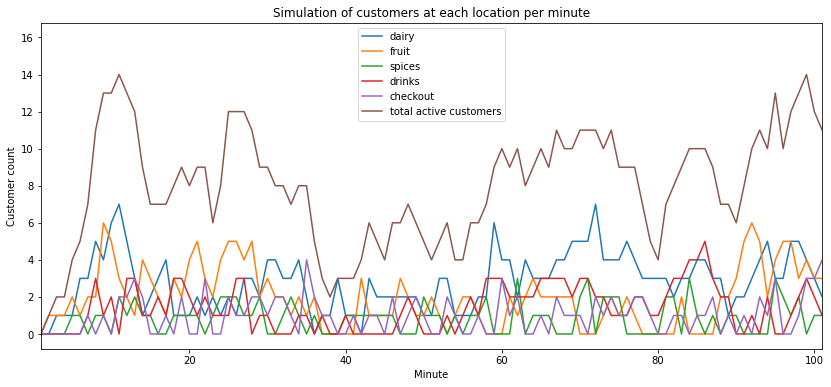

In [1940]:
# Plot simulation predicting customer counts at each location per minute
sim_plot = minute_counts.plot(figsize=(14,6))
sim_plot.set_title('Simulation of customers at each location per minute')
sim_plot.set_xlabel('Minute')
sim_plot.set_ylabel('Customer count')
sim_plot.set_xlim([1,101]) # Checking specific range starting from minute after entrance